# Plot Statistics Output from the MODIS Global and Fixed Site Tools

*Date: April 4, 2018*  
*Contact for ORNL DAAC: uso@daac.ornl.gov*

### Keywords: MODIS, R

## Overview

This document demonstrates how to generate informative plots from the statistics outputs of the **[MODIS Global Tool](https://modis.ornl.gov/cgi-bin/MODIS/global/subset.pl)** and **[MODIS Fixed Sites Tool](https://modis.ornl.gov/sites/)** maintained by the ORNL DAAC. 

ORNL DAAC. 2017. MODIS Collection 6 Land Products Fixed Sites Subsetting and Visualization Tool. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1567  

ORNL DAAC. 2017. MODIS Collection 6 Land Products Global Subsetting and Visualization Tool. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1379  

## Source Data

Data inputs are comma-delimited text files from the two tools named *statistics_[modis_product_band].csv*. In this example, we will use MOD11A2 Land Surface Temperature statistics calculated for the [Iowa Des Moines 17 E](https://modis.ornl.gov/cgi-bin/sites/site.pl?id=us_iowa_ia_des_moines_17_e&product=MOD11A2) site. Summary statistics are generated for all global tool orders and fixed sites and are available in the download section of the order delivery page/fixed site page. See below:

![statscsv](modis/images/download_stats.PNG)

## Requirements

R (3.x)  
R libraries: ggplot2, viridis  

## Outputs

This R script generates the following plots:  

1. plot of subset mean value and variation over time
2. plot of subset mean values summarized by month
3. plot of subset mean values summarized by year
4. frequency histogram plot of all subset area mean values
5. timeseries plot with years stacked and a loess smoothed fit curve for each year
6. plot subset area mean grouped by year and month

Make sure that the *statistics_[modis_product_band].csv* for your order in your working directory. 

### Read and prepare the data

In [1]:
rm(list = ls()) # clear the workspace

product <- "LST_Day_1km" # set the product (and band)

# Note: this script must be run from the same directory that contains the statistics file.
stat_fname <- paste("statistics_", product, ".csv", sep='') 

In [2]:
#### Load required packages. You may need to run install.packages('package') if you have not used these before.
library(ggplot2) #package for plotting
library(viridis) # package for nice color scheme

#### Read in data
stat_fname <- paste("statistics_", product, ".csv", sep='')
subset_stats <- read.csv(stat_fname, head=TRUE, sep=",")
summary(subset_stats) # get basic summary information about the data

# Format dates and add to dataframe
dates <- as.Date(subset_stats$date)
years <- format(dates, format = "%Y")
n_yrs <- length(unique(years)) # calculate number of years in subset
months <- format(dates, format = "%m")
monthAbbrev <- format(dates, format = "%b")
DOY <- as.numeric(substr(subset_stats$date.YYYYDDD.,6,8)) #to find the day of year (DOY), take the last three digits of date.YYYYDDD. which is an eight digit string

# find the 68% confidence intervals around the mean
y1 <- subset_stats$mean + subset_stats$standard_deviation 
y2 <- subset_stats$mean - subset_stats$standard_deviation

# add to main data frame
subset_stats <- cbind(subset_stats, DOY, months, years, y1, y2)

  date.YYYYDDD.         date        product             band    
 A2000049:  1   2000-02-18:  1   MOD11A2:804   LST_Day_1km:804  
 A2000057:  1   2000-02-26:  1                                  
 A2000065:  1   2000-03-05:  1                                  
 A2000073:  1   2000-03-13:  1                                  
 A2000081:  1   2000-03-21:  1                                  
 A2000089:  1   2000-03-29:  1                                  
 (Other) :798   (Other)   :798                                  
      min             max             sum              range      
 Min.   :250.3   Min.   :256.2   Min.   :  256.8   Min.   : 0.00  
 1st Qu.:277.6   1st Qu.:281.8   1st Qu.:22424.8   1st Qu.: 2.20  
 Median :292.7   Median :296.6   Median :23780.0   Median : 3.32  
 Mean   :287.7   Mean   :291.8   Mean   :22588.9   Mean   : 4.08  
 3rd Qu.:298.4   3rd Qu.:302.1   3rd Qu.:24297.0   3rd Qu.: 5.20  
 Max.   :305.5   Max.   :313.1   Max.   :25050.0   Max.   :24.98  
 NA's   :19

### Figure 1: mean and variation timeseries: subset mean is a dark line and 68% CI is a shaded region  

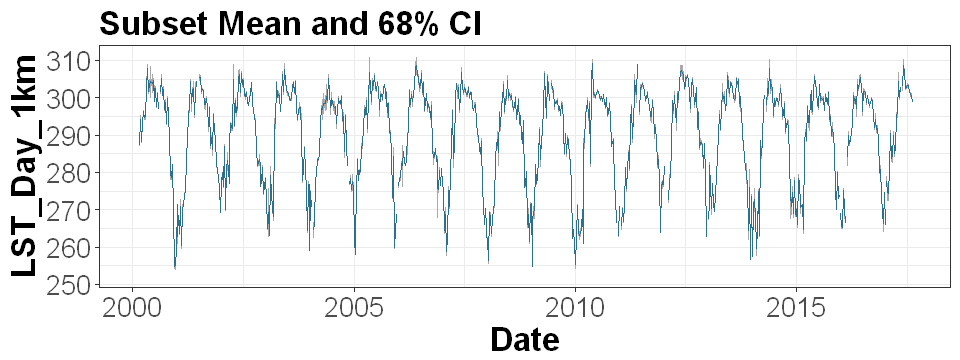

In [3]:
#### Figure 1: mean and variation timeseries: subset mean is a dark line and 68% CI is a shaded region  
F1 <- ggplot(subset_stats, aes(x=as.Date(date), y = mean)) + 
  geom_ribbon(aes(ymin=y2, ymax=y1), fill = "darkgray") + # draw the shaded area for 68% CI
  geom_line(colour = "#2D708EFF", aes(y=mean)) + # draw the line for the mean value
  ggtitle("Subset Mean and 68% CI") + # add a title
  ylab(product) + # add a y-axis label
  xlab("Date") + # add a x-axis label
  theme_bw() + # set the plot theme
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), axis.title.x = element_text(face="bold", size=20), axis.title.y = element_text(face="bold", size=20), axis.text.x = element_text(size=16), axis.text.y = element_text(size=16)) # set optional theme elements

F1

### Figure 2: mean monthly values for the subset

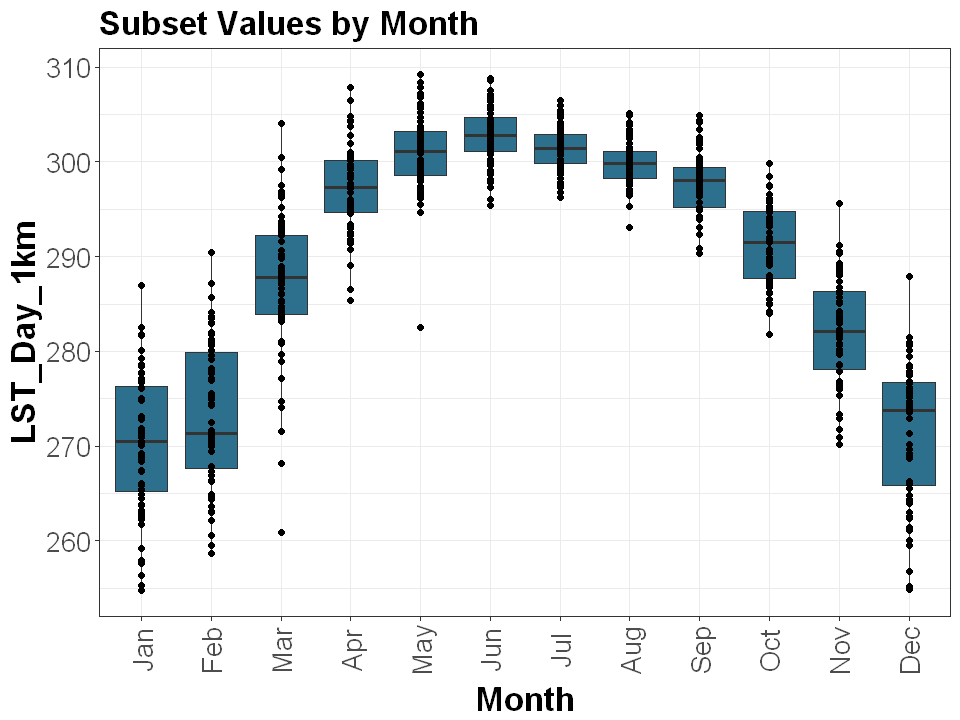

In [4]:
#### Figure 2: mean monthly values for the subset
F2 <- ggplot(subset_stats, aes(factor(months), mean)) +
  geom_boxplot(fill="#2D708EFF") + 
  geom_jitter(width = 0) + 
  ggtitle("Subset Values by Month") + 
  scale_x_discrete(breaks= months, labels=monthAbbrev) + 
  xlab("Month") + 
  ylab(product) + 
  theme_bw() +
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), legend.position="none", axis.title.x = element_text(face="bold", size=20), axis.text.x = element_text(angle=90, vjust=0.5, size=16), axis.title.y = element_text(face="bold", size=20), axis.text.y = element_text(size=16)) +
  guides(fill=FALSE)

F2

### Figure 3: mean yearly values for the subset

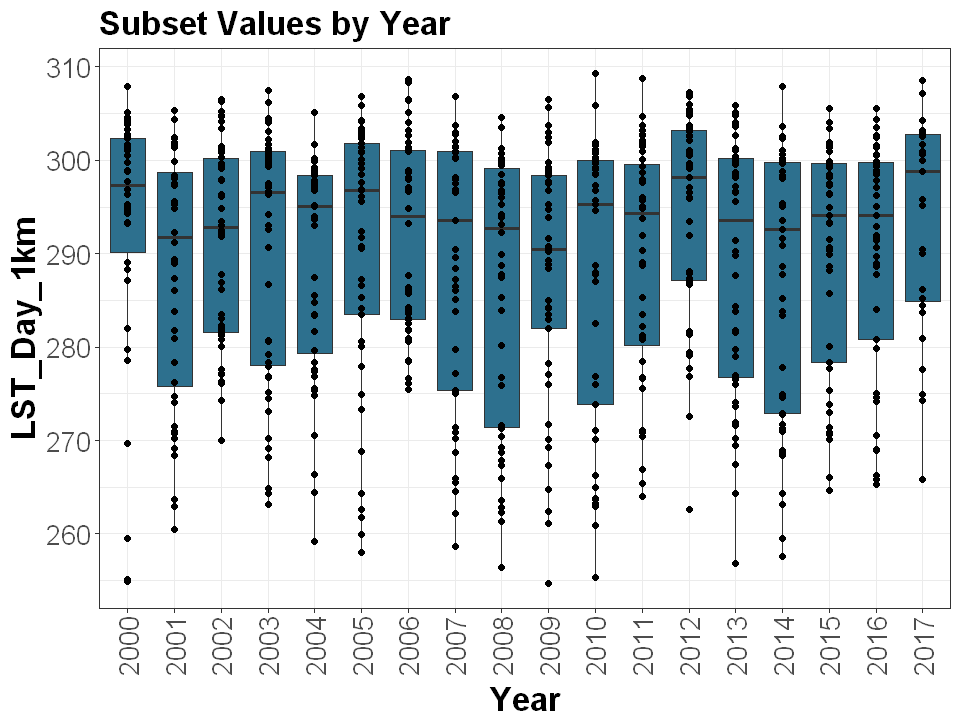

In [5]:
F3 <- ggplot(subset_stats, aes(factor(years), mean)) +
  geom_boxplot(fill="#2D708EFF") + 
  geom_jitter(width = 0) + 
  ggtitle("Subset Values by Year") + 
  scale_x_discrete(breaks= years, labels=years) + 
  xlab("Year") + 
  ylab(product) + 
  theme_bw() +
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), legend.position="none", axis.title.x = element_text(face="bold", size=20), axis.text.x = element_text(angle=90, vjust=0.5, size=16), axis.title.y = element_text(face="bold", size=20), axis.text.y = element_text(size=16)) +
  guides(fill=FALSE)

F3

### Figure 4: frequency histogram of all subset mean values 

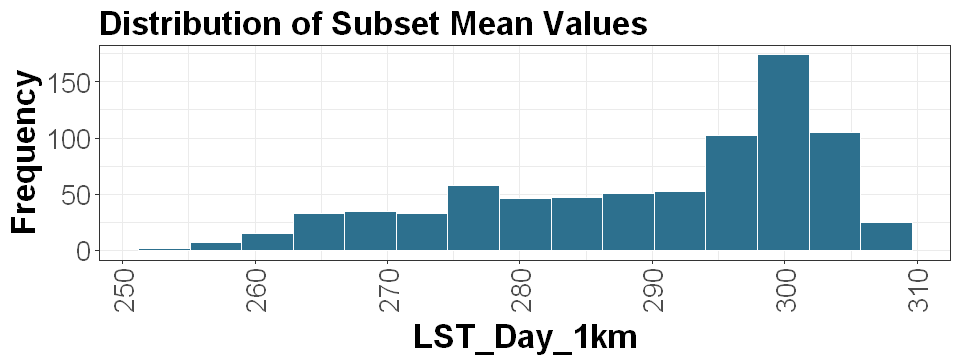

In [6]:
F4 <- ggplot(subset_stats, aes(x=mean)) + 
  geom_histogram(bins=15, fill="#2D708EFF", color="white") + 
  ggtitle("Distribution of Subset Mean Values") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20)) + 
  ylab("Frequency") + 
  xlab(product) + 
  theme_bw() +
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), legend.position="none", axis.title.x = element_text(face="bold", size=20), axis.text.x = element_text(angle=90, vjust=0.5, size=16), axis.title.y = element_text(face="bold", size=20), axis.text.y = element_text(size=16))

F4

### Figure 5: timeseries with years stacked and a loess smoothed fit curve for each year

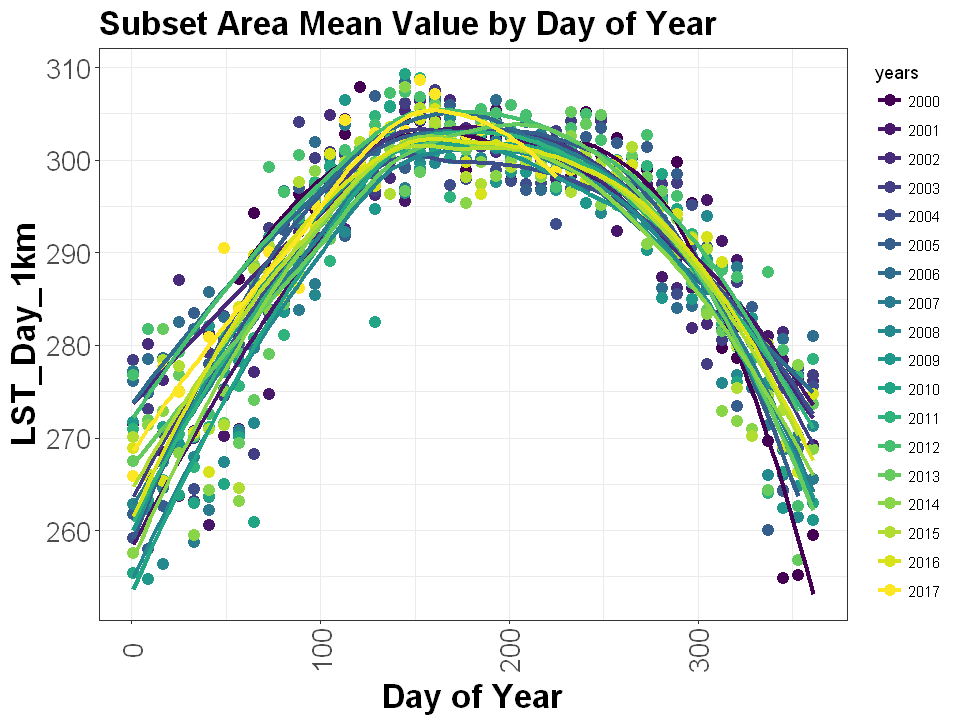

In [7]:
F5 <- ggplot(subset_stats, aes(x=DOY, y=mean, color=years)) + 
  scale_color_viridis(discrete=T) + 
  geom_point(size=3) + 
  geom_smooth(aes(factor=years), se=FALSE, size=1.2) + 
  ggtitle("Subset Area Mean Value by Day of Year") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20)) + 
  xlab("Day of Year") + 
  ylab(product) + 
  theme_bw() +
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), axis.title.x = element_text(face="bold", size=20), axis.text.x = element_text(angle=90, vjust=0.5, size=16), axis.title.y = element_text(face="bold", size=20), axis.text.y = element_text(size=16)) 

F5

### Figure 6: subset area mean grouped by year and month

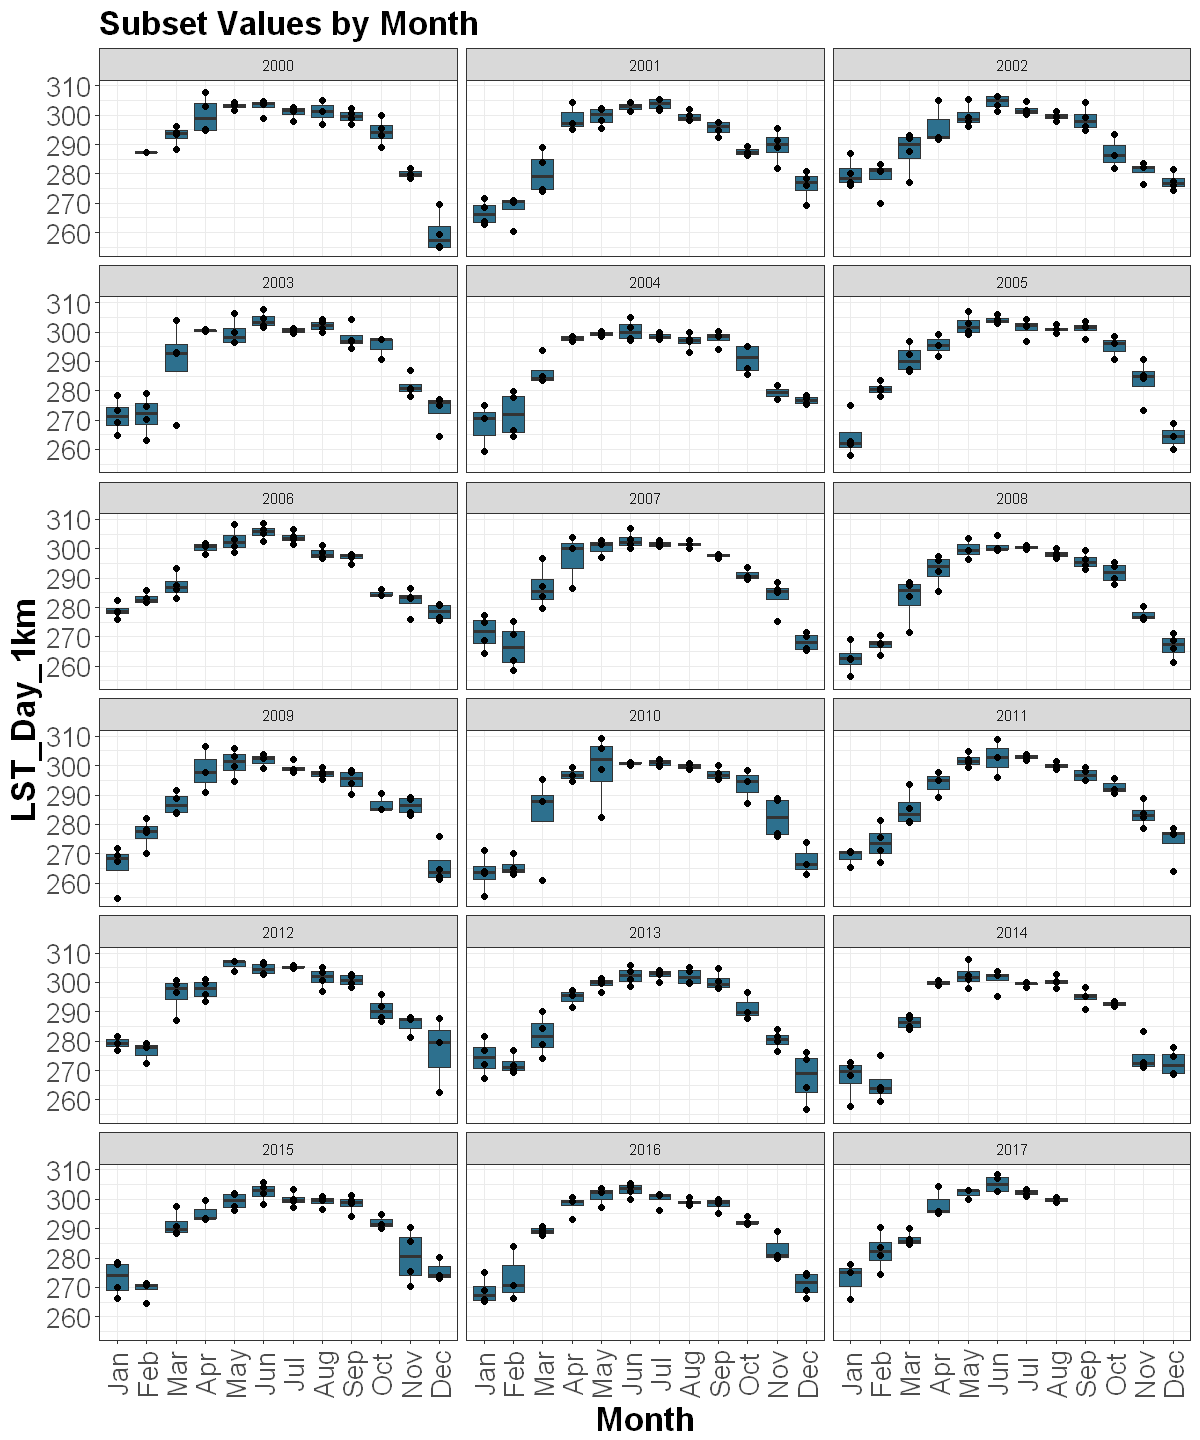

In [8]:
F6 <- ggplot(subset_stats, aes(factor(months), mean)) +
  geom_boxplot(fill="#2D708EFF") + 
  geom_jitter(width = 0) +  
  facet_wrap(~ years, ncol=3) +
  ggtitle("Subset Values by Month") + 
  scale_x_discrete(breaks=months, labels=monthAbbrev) + 
  xlab("Month") + 
  ylab(product) + 
  theme_bw() +
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), legend.position="none", axis.title.x = element_text(face="bold", size=20), axis.text.x = element_text(angle=90, vjust=0.5, size=16), axis.title.y = element_text(face="bold", size=20), axis.text.y = element_text(size=16))

F6